In [1]:
# General imports and settings

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL
import utils
from utils import get_json_data, load_images, load_specific_image
from IPython.display import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = get_json_data('GoT_Face_Labelling_Ep7.json')

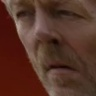

Jorah Mormont


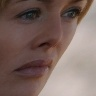

Cersei Lannister


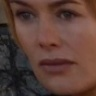

Cersei Lannister


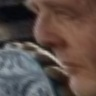

Qyburn


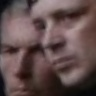

Unknown Person


In [3]:
# Examples of the faces given in the dataset
for i in range(5):
    rand_entry = np.random.randint(1, 1300)
    X = load_specific_image(data, rand_entry)
    display(Image(filename='data/data_%s.jpg' % (rand_entry)))
    print(data[rand_entry]['annotation']['label'][0])


In [4]:
# Create the data dict with the training examples and labels. 
# Set num_of_training (No. of examples) be a nuber between 1 to 1300 and num_of_validation between 1 to num_of_training 
num_of_training = 1200
num_of_validation = 100
data_dict = utils.load_images_and_get_data(data, num_of_training, num_of_validation, flip=True)

In [5]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.reset_default_graph()

In [6]:
def cnn_model_fn(features, labels, mode):
    """CNN model function"""
    
    input_layer = tf.reshape(features["x"], [-1, 96, 96, 3])
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=32,
                            kernel_size=5,
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides =2)
    conv2 = tf.layers.conv2d(inputs=pool1,
                            filters=32,
                            kernel_size=3,
                            padding="same",
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides =2)
    conv3 = tf.layers.conv2d(inputs=pool2,
                            filters=32,
                            kernel_size=3,
                            padding="same",
                            activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=2, strides =2)
    pool3_flat = tf.reshape(pool3, [-1, 24 * 24 * 32])
    dense = tf.layers.dense(inputs=pool3_flat, units=18432, activation=tf.nn.relu)
    #dropout = tf.layers.dropout(inputs=dense, rate=0.2, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    logits = tf.layers.dense(inputs=dense, units=69)
    classes = tf.as_string(tf.argmax(input=logits, axis=1, name="class"))
    predictions = {
        "classes" : tf.argmax(input=logits, axis=1),
        "probabilities" : tf.nn.softmax(logits, name="softmax_tensor")
        }
        
    if mode == tf.estimator.ModeKeys.PREDICT:
        export_outputs = {"classes" : tf.estimator.export.ClassificationOutput(classes=classes)}
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions, export_outputs=export_outputs)
    
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth = 69)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        metrics = {
            "accuracy" : tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
        }
        tf.summary.scalar("accuracy", metrics["accuracy"][1])
        merge_summary_op = tf.summary.merge_all
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    eval_metrics_op = {"accuracy" : tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics_op)

In [7]:
got_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="train/train_0/")
tensors_to_log = {"probabilities" : "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=300)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'train/train_0/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f60f27e3278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
training_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x" : data_dict['X_train']},
                                                       y=data_dict['y_train'],
                                                       batch_size=50,
                                                       num_epochs=None,
                                                       shuffle=True)
got_classifier.train(input_fn=training_input_fn, steps=10, hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from train/train_0/model.ckpt-2601
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2602 into train/train_0/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.00000283 0.00000268]
 [0.         0.         0.         ... 0.         0.00000019 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00000032 0.        ]
 [0.         0.         0.         ... 0.         0.00000078 0.        ]
 [0.         0.         0.         ... 0.         0.00001896 0.00000496]]
INFO:tensorflow:loss = 3.0303554e-05, step = 2602
INFO:tensorflow:Saving checkpoints for 2611 into train/train_0/model.ckpt.
INFO:tensorflow

In [9]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x" : data_dict['X_eval']},
                                                   y=data_dict['y_eval'],
                                                   num_epochs=1,
                                                   shuffle=False)
eval_results = got_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-28-07:20:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from train/train_0/model.ckpt-2611
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-28-07:20:30
INFO:tensorflow:Saving dict for global step 2611: accuracy = 0.77, global_step = 2611, loss = 1.3146713
{'accuracy': 0.77, 'loss': 1.3146713, 'global_step': 2611}


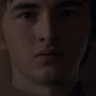

This is Unknown Person
0.71933913


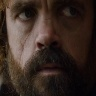

This is Tyrion Lannister
1.0


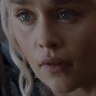

This is Daenerys Targaryen
1.0


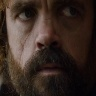

This is Tyrion Lannister
1.0


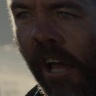

This is Unknown Person
0.99988353


In [10]:
# Examples of predictions on data which was not used for training or evaluation
from utils import load_specific_image, num_to_name
tf.logging.set_verbosity(tf.logging.ERROR)
for i in range(5):
    rand_entry = np.random.randint(num_of_training, 1300)
    X = load_specific_image(data, rand_entry)
    display(Image(filename='data/data_%s.jpg' % (rand_entry)))

    predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x" : X}, num_epochs=1, shuffle = False)
    predictions = list(got_classifier.predict(input_fn=predict_input_fn))
    print("This is {}".format(num_to_name(predictions[0]["classes"])))
    print(predictions[0]["probabilities"][predictions[0]["classes"]])

In [17]:
# Export model
def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    serialized_tf_example = tf.placeholder(dtype=tf.string, shape=[None], name='input_tensors')
    receiver_tensors = {"predictor_inputs" : serialized_tf_example}
    feature_spec = {"x" : tf.FixedLenFeature([96, 96 ,3], tf.float32)}
    features = tf.parse_example(serialized_tf_example, feature_spec)
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

exported_model = got_classifier.export_savedmodel("trained/trained_0", serving_input_receiver_fn=serving_input_receiver_fn)